<a href="#" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

In this notebook, we will train a 3D U-Net model for CT image segmentation. To achieve this, we used a dataset containing four patients: two for training, one for validation, and one for testing.diseases, and also provide important information for machine learning models.

**Downloading Dataset**


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload() # upload your Kaggle.json API token

Saving kaggle (2).json to kaggle (2) (1).json


{'kaggle (2) (1).json': b'{"username":"alkad7038","key":"39c9037ec5f7e8e5a63a782e8c30c10a"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d kmader/finding-lungs-in-ct-data

Dataset URL: https://www.kaggle.com/datasets/kmader/finding-lungs-in-ct-data
License(s): unknown
finding-lungs-in-ct-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/finding-lungs-in-ct-data.zip

Archive:  /content/finding-lungs-in-ct-data.zip
replace 2d_images.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: 2d_images.zip           
  inflating: 2d_images/ID_0000_Z_0142.tif  
  inflating: 2d_images/ID_0001_Z_0146.tif  
  inflating: 2d_images/ID_0002_Z_0162.tif  
  inflating: 2d_images/ID_0003_Z_0132.tif  
  inflating: 2d_images/ID_0004_Z_0066.tif  
  inflating: 2d_images/ID_0005_Z_0066.tif  
  inflating: 2d_images/ID_0006_Z_0206.tif  
  inflating: 2d_images/ID_0007_Z_0211.tif  
  inflating: 2d_images/ID_0008_Z_0065.tif  
  inflating: 2d_images/ID_0009_Z_0114.tif  
  inflating: 2d_images/ID_0010_Z_0259.tif  
  inflating: 2d_images/ID_0011_Z_0156.tif  
  inflating: 2d_images/ID_0012_Z_0167.tif  
  inflating: 2d_images/ID_0013_Z_0047.tif  
  inflating: 2d_images/ID_0014_Z_0116.tif  
  inflating: 2d_images/ID_0015_Z_0136.tif  
  inflating: 2d_images/ID_0016_Z_0208.tif  
  inflating: 2d_images/ID_0017_Z_0061.tif  
  inflating: 2d_images/ID_0018_Z_0069.tif  
  inflating: 2d

**Import Libraries**

In [ ]:
import os
import glob
import torch
import numpy as np
import nibabel as nib

import matplotlib.pyplot as plt
%matplotlib inline

**Visualize Data**

In [ ]:
data_dir = '/content/3d_images'
images = sorted(
    glob.glob(os.path.join(data_dir, "IMG*.nii.gz")))
labels = sorted(
    glob.glob(os.path.join(data_dir, "MASK*.nii.gz")))

print('No. of images:', len(images), ' labels:', len(labels))

No. of images: 4  labels: 4


img shape: (325, 512, 512)  lbl shape: (325, 512, 512)
img intensity min.: -933.0  max.: 2675.0  unique labels: [  0. 255.]


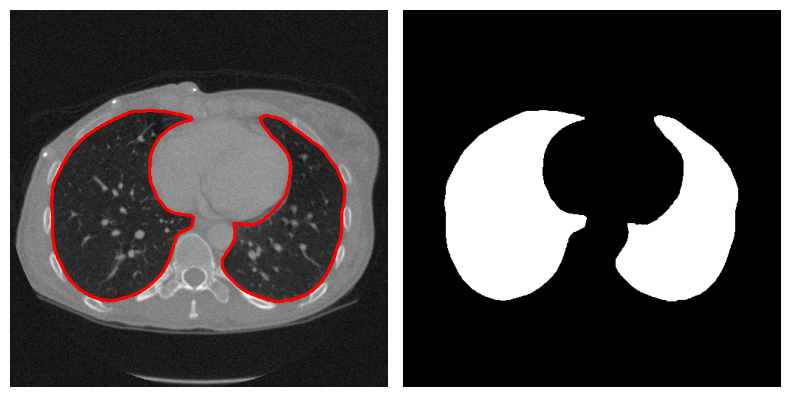

In [ ]:
img = nib.load(images[0]).get_fdata()
lbl = nib.load(labels[0]).get_fdata()
print('img shape:', img.shape, ' lbl shape:', lbl.shape)
print('img intensity min.:', np.min(img), ' max.:', np.max(img), ' unique labels:', np.unique(lbl))

slice_idx = 100
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.imshow(img[slice_idx], cmap='gray', vmin=-1000, vmax=1000)
plt.contour(lbl[slice_idx], colors='red')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(lbl[slice_idx], cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

**Set Determinism for Reproducibility of Results**

In this tutorial, we use the MONAI library, a popular open-source library for medical imaging. We start by installing the library and set a seed for determinism. The set_determinism function from the monai.utils module, allows us to set the seed for random number generation, which ensures that the model training process is deterministic and reproducible.

In [ ]:
!#pip install --upgrade --force-reinstall numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 68.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
monai 1.4.0 requires numpy<2.0,>=1.24, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.


In [ ]:
#!pip install --upgrade --force-reinstall monai

  Using cached monai-1.4.0-py3-none-any.whl.metadata (11 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-man

In [ ]:
from monai.utils import first, set_determinism

set_determinism(seed=0)

Next, we define a dict that includes image and label paths for each patient. As this dataset contains only 4 patients, we use 2, 1 and 1 patients for training, validation and testing respectively.

In [ ]:
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(images, labels)
]

train_files, val_files, test_files = data_dicts[:2], data_dicts[2:3], data_dicts[-1:]

print('train files:', len(train_files), ' val files:', len(val_files), ' test files:', len(test_files))


train files: 2  val files: 1  test files: 1


**Defining Image Preprocessing Transforms**

This code is designed to define preprocessing transformations for both the training and validation datasets. The "Compose" function is used to build two separate transformation pipelines: one dedicated to training and the other to validation. A crucial transformation in this process is "RandSpatialCropd", which randomly extracts cubic patches of size (96, 96, 96) from the training images and their corresponding label volumes.

Patch-based training provides several key benefits. It increases the amount of training data available, preserves spatial information that would otherwise be lost in 2D approaches, and enhances prediction consistency by incorporating results from multiple patches. The training transformations include various data augmentation techniques, such as random spatial cropping, rotation, scaling, flipping, and intensity adjustments. In contrast, the validation transformations focus solely on basic preprocessing.

This preprocessing framework is essential for preparing data for stochastic model training and validation, ensuring that the necessary transformations are applied effectively. Moreover, it offers flexibility, allowing easy adjustments to the data augmentation process depending on the specific task and dataset.

In [ ]:
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandAffined,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1000, a_max=1000,
            b_min=0.0, b_max=1.0, clip=True,
        ),

        # Change labels from 255 to 1
        ScaleIntensityRanged(
            keys=["label"], a_min=0, a_max=255,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="PLS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),

        # Randomly crop a patch from both image and label files
        RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[96, 96, 96],
                random_size=False,
        ),

        # Data augmentation transforms
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=1.0, spatial_size=(96, 96, 96),
            rotate_range=(0, 0, np.pi/15),
            scale_range=(0.1, 0.1, 0.1)),
        RandFlipd(keys=["image", "label"], prob=0.25, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.25, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.25, spatial_axis=2),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ])

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1000, a_max=1000,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        ScaleIntensityRanged(
            keys=["label"], a_min=0, a_max=255,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="PLS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ])

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


We can now visualize a sample patch from our training dataset.

img shape: torch.Size([96, 96, 96]), lbl shape: torch.Size([96, 96, 96])


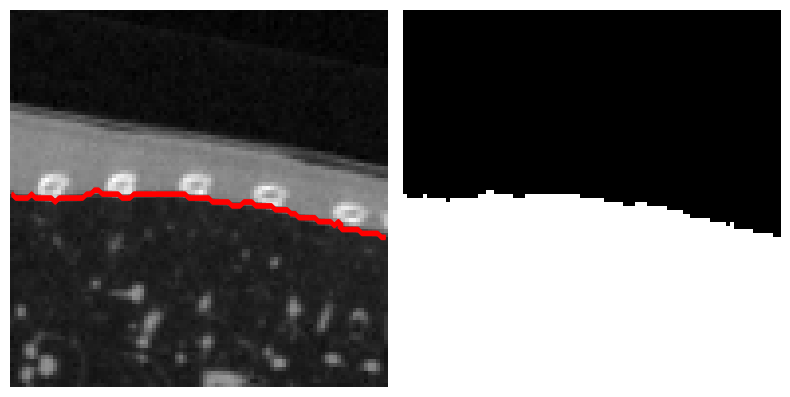

In [ ]:
sample_ds = Dataset(data=train_files, transform=train_transforms)
sample_dataloader = DataLoader(sample_ds, batch_size=1)
sample_batch = first(sample_dataloader)

img, lbl = sample_batch["image"][0][0], sample_batch["label"][0][0]
print(f"img shape: {img.shape}, lbl shape: {lbl.shape}")

slice_idx = 64
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.imshow(img[:,:,slice_idx], cmap='gray')
plt.contour(lbl[:,:,slice_idx], colors='red')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(lbl[:,:,slice_idx], cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

We now generate dataloaders for the training and validation datasets using the **MONAI** library. The **CacheDataset** class facilitates this process by defining the file paths, preprocessing transformations, cache rate, and the number of workers for parallel processing.  

As part of the **MONAI** library, **CacheDataset** is designed to create datasets from a list of data files and a transformation function. By caching preprocessed data in memory, it significantly speeds up data access during training, making it especially beneficial for handling large datasets efficiently.

In [ ]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)
val_loader = DataLoader(val_ds, batch_size=1)

Loading dataset: 100%|██████████| 1/1 [00:08<00:00,  8.95s/it]


**Define Model, Loss Function and Optimizer**

The loss function is DiceLoss, the optimizer is Adam, and the evaluation metric is DiceMetric. These components are essential for training and evaluating the performance of the model.

In [ ]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.networks.layers import Norm

device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

Finally, we can train our model and evaluate its performance on the validation set using image volumes. By utilizing the sliding_window_inference algorithm, we can predict the masks from multiple patches within the image volume. To ensure the best performance, we save the weights from the epoch that yields the highest overall performance. We train our model for a total of 500 epochs.

In [ ]:
from monai.inferers import sliding_window_inference

# Define hyperparameters
max_epochs = 500
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

# Define post-processing transforms
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

# Training loop
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device),
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 1, model)

                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]

                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()

            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/500
1/1, train_loss: 0.5442
epoch 1 average loss: 0.5442
----------
epoch 2/500
1/1, train_loss: 0.5001
epoch 2 average loss: 0.5001
saved new best metric model
current epoch: 2 current mean dice: 0.2778
best mean dice: 0.2778 at epoch: 2
----------
epoch 3/500
1/1, train_loss: 0.5447
epoch 3 average loss: 0.5447
----------
epoch 4/500
1/1, train_loss: 0.5211
epoch 4 average loss: 0.5211
current epoch: 4 current mean dice: 0.2776
best mean dice: 0.2778 at epoch: 2
----------
epoch 5/500
1/1, train_loss: 0.5643
epoch 5 average loss: 0.5643
----------
epoch 6/500
1/1, train_loss: 0.5853
epoch 6 average loss: 0.5853
current epoch: 6 current mean dice: 0.2778
best mean dice: 0.2778 at epoch: 2
----------
epoch 7/500
1/1, train_loss: 0.4435
epoch 7 average loss: 0.4435
----------
epoch 8/500
1/1, train_loss: 0.5088
epoch 8 average loss: 0.5088
saved new best metric model
current epoch: 8 current mean dice: 0.2785
best mean dice: 0.2785 at epoch: 8
----------
epoch 9/500
1

In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.9610 at epoch: 496


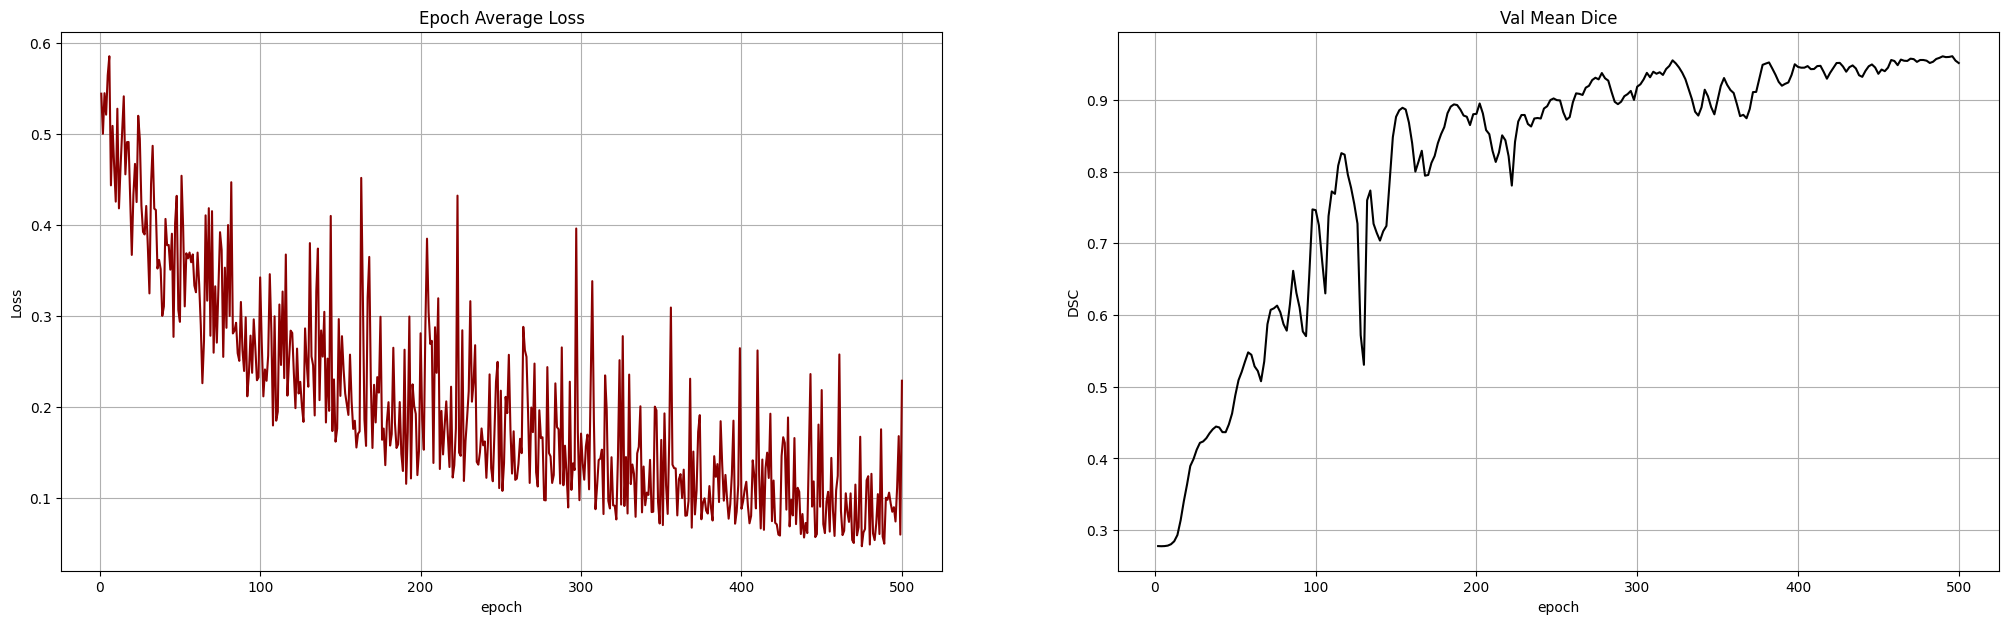

In [ ]:
plt.figure("train", (25,7))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.plot(x, y, color='darkred')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.ylabel("DSC")
plt.xlabel("epoch")
plt.grid(True)
plt.plot(x, y, color='black')
plt.show()

**Make Predictions from Test Data**

This code is creating a test dataset, loading it and applying post-processing transforms on the data. It is created by using the "test_files" variable, which contains the file paths of the test images, and the "val_transforms" transformation, which applies pre-processing operations on the images.

The post-processing transforms are defined using the "Compose" function. The "Invertd" function allows reverting the preprocessing steps and convert the predictions back to the original image spacing.

The next step is "AsDiscreted" transform that is a post-processing step for converting the image data into discrete values. Specifically, it applies the argmax method on the image data, which selects the class with the highest probability at each pixel/voxel. Then, the AsDiscreted transform converts the image data into one-hot format with 2 classes.

In [ ]:
test_ds = Dataset(data=test_files, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

post_transforms = Compose([
    Invertd(
        keys="pred",
        transform=val_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
])

With the trained model, we can now segment the lungs from the test data. We employ the sliding window inference technique with 75% patch overlap to predict the lung mask volume. Despite the limited training data, comprising of only 2 patients for training and 1 for validation, the model exhibits outstanding performance. However, it's worth noting that the limited training data may lead to overfitting, which can be mitigated by using transfer learning techniques to improve the model's performance and generalizability.

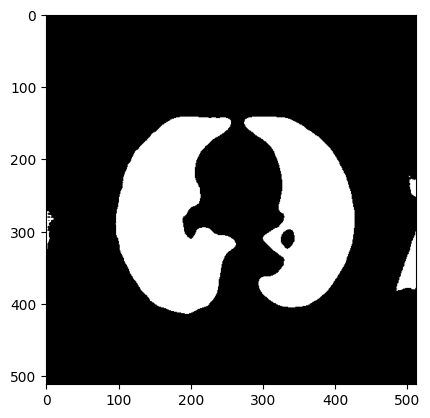

In [ ]:
plt.imshow(np.squeeze(test_output[0].detach().cpu().numpy()[1, slice_idx]), cmap="gray") # index 0 pour la classe prédite

Original image shape: torch.Size([117, 512, 512])
Original label shape: torch.Size([117, 512, 512])
2025-03-18 14:03:13,053 INFO image_writer.py:197 - writing: out/IMG_0078/IMG_0078_seg.nii.gz


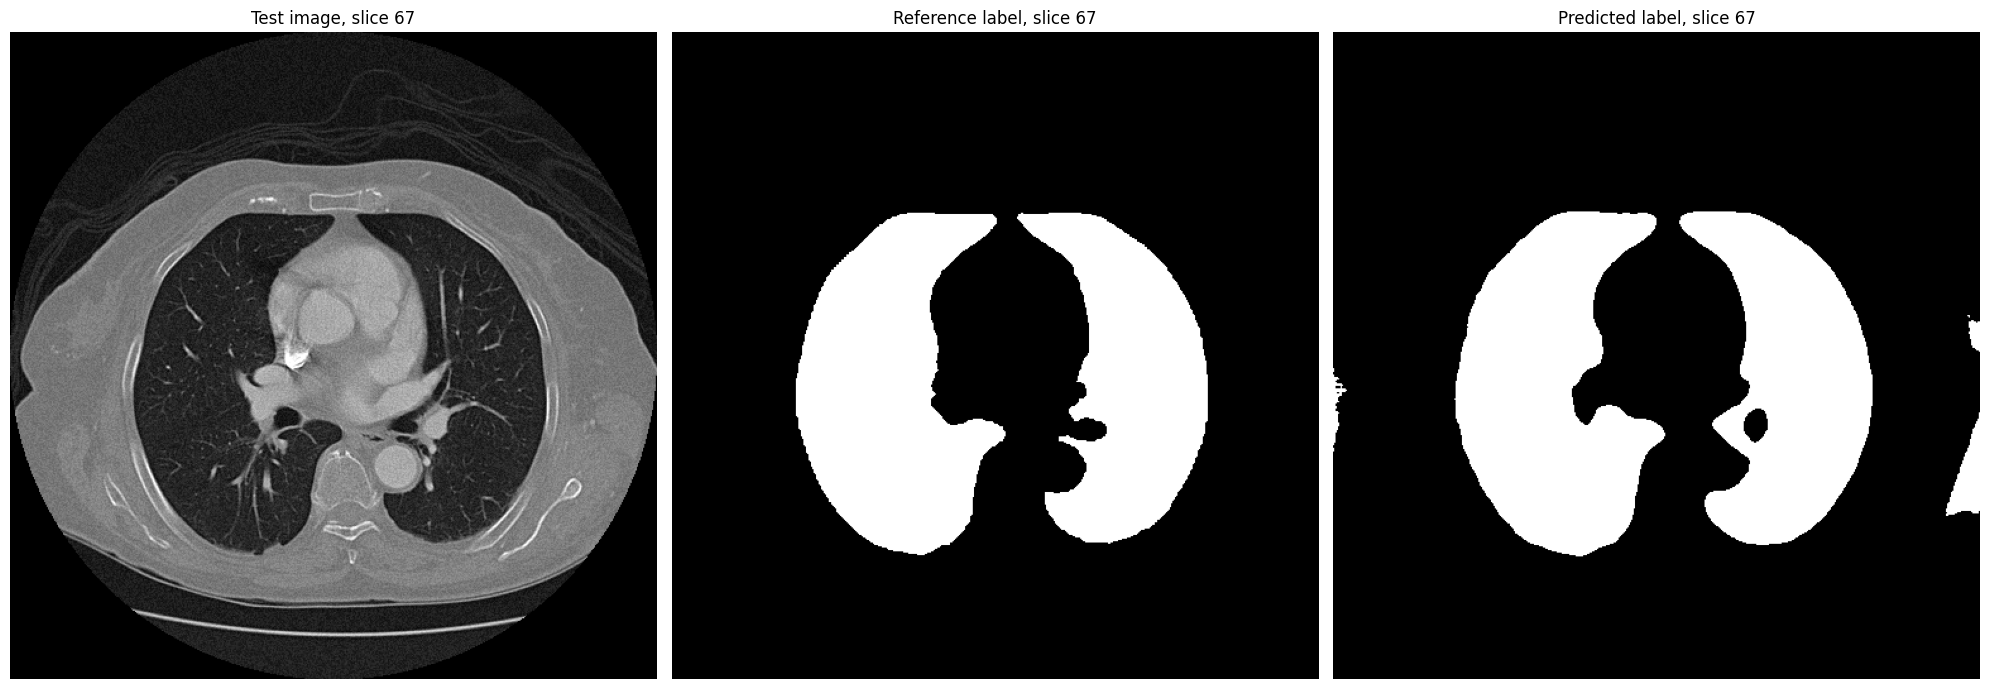

In [ ]:
import torch
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from monai.transforms import LoadImaged
from monai.inferers import sliding_window_inference
from monai.handlers.utils import from_engine
from monai.data import decollate_batch

# Charger les images avec nibabel
image_path = test_files[0]['image']
label_path = test_files[0]['label']

image_data = nib.load(image_path).get_fdata()
label_data = nib.load(label_path).get_fdata()

# Convertir en tensors PyTorch
original_image = torch.from_numpy(image_data).float()
original_label = torch.from_numpy(label_data).float()

# Vérifier la forme des images
print("Original image shape:", original_image.shape)
print("Original label shape:", original_label.shape)

# Choisir une coupe 2D
slice_idx = 67
image_slice_2d = original_image[slice_idx].detach().cpu().numpy()
label_slice_2d = original_label[slice_idx].detach().cpu().numpy()

# Charger le modèle
model.load_state_dict(torch.load("best_metric_model.pth", map_location="cpu"))
model.eval()

# Exécuter l'inférence
with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = sliding_window_inference(test_inputs, (96, 96, 96), 1, model, overlap=0.75)
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_output = from_engine(["pred"])(test_data)
        break  # Un seul batch

# Extraire la prédiction pour la classe "poumon" (index 1)
predicted_mask = torch.argmax(test_output[0], dim=0)  # Réduction sur l'axe des classes
predicted_slice = predicted_mask[slice_idx].detach().cpu().numpy()

# Afficher les résultats
plt.figure(figsize=(20, 7))

# Image originale
plt.subplot(1, 3, 1)
plt.imshow(image_slice_2d, cmap="gray", vmin=-1000, vmax=1000)
plt.title(f'Test image, slice {slice_idx}')
plt.axis('off')

# Label de référence
plt.subplot(1, 3, 2)
plt.imshow(label_slice_2d, cmap="gray")
plt.title(f'Reference label, slice {slice_idx}')
plt.axis('off')

# Prédiction
plt.subplot(1, 3, 3)
plt.imshow(predicted_slice, cmap="gray")
plt.title(f'Predicted label, slice {slice_idx}')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import nibabel as nib
import numpy as np

# Charger le masque de référence
label_path = test_files[0]['label']
label_data = nib.load(label_path).get_fdata()
label_data = (label_data > 0).astype(np.int32)  # Binariser le masque de référence
print("Nombre de voxels dans le masque de référence :", np.sum(label_data))

# Charger le masque prédit
predicted_data = val_outputs[0].detach().cpu().numpy()  # Récupérer la prédiction
predicted_data = (predicted_data > 0.5).astype(np.int32)  # Binariser la prédiction
print("Nombre de voxels dans le masque prédit :", np.sum(predicted_data))

# Résolution des voxels (en mm)
#voxel_volume = 1.5 * 1.5 * 2.0  # en mm³
#print("Volume d'un voxel (mm³):", voxel_volume)

# Calculer le volume du masque de référence
#voxel_count_label = np.sum(label_data)
#lung_volume_label_mm3 = voxel_count_label * voxel_volume
#lung_volume_label_cm3 = lung_volume_label_mm3 / 1000  # Convertir en cm³

# Calculer le volume du masque prédit
#voxel_count_pred = np.sum(predicted_data)
#lung_volume_pred_mm3 = voxel_count_pred * voxel_volume
#lung_volume_pred_cm3 = lung_volume_pred_mm3 / 1000  # Convertir en cm³

#print(f"Volume du poumon (référence) : {lung_volume_label_mm3} mm³ ({lung_volume_label_cm3} cm³)")
#print(f"Volume du poumon (prédit) : {lung_volume_pred_mm3} mm³ ({lung_volume_pred_cm3} cm³)")

Nombre de voxels dans le masque de référence : 2966148
Nombre de voxels dans le masque prédit : 5299767
Volume d'un voxel (mm³): 4.5
Volume du poumon (référence) : 13347666.0 mm³ (13347.666 cm³)
Volume du poumon (prédit) : 23848951.5 mm³ (23848.9515 cm³)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Original image shape: torch.Size([117, 512, 512])
Original label shape: torch.Size([117, 512, 512])
2025-03-18 14:16:24,000 INFO image_writer.py:197 - writing: out/IMG_0078/IMG_0078_seg.nii.gz


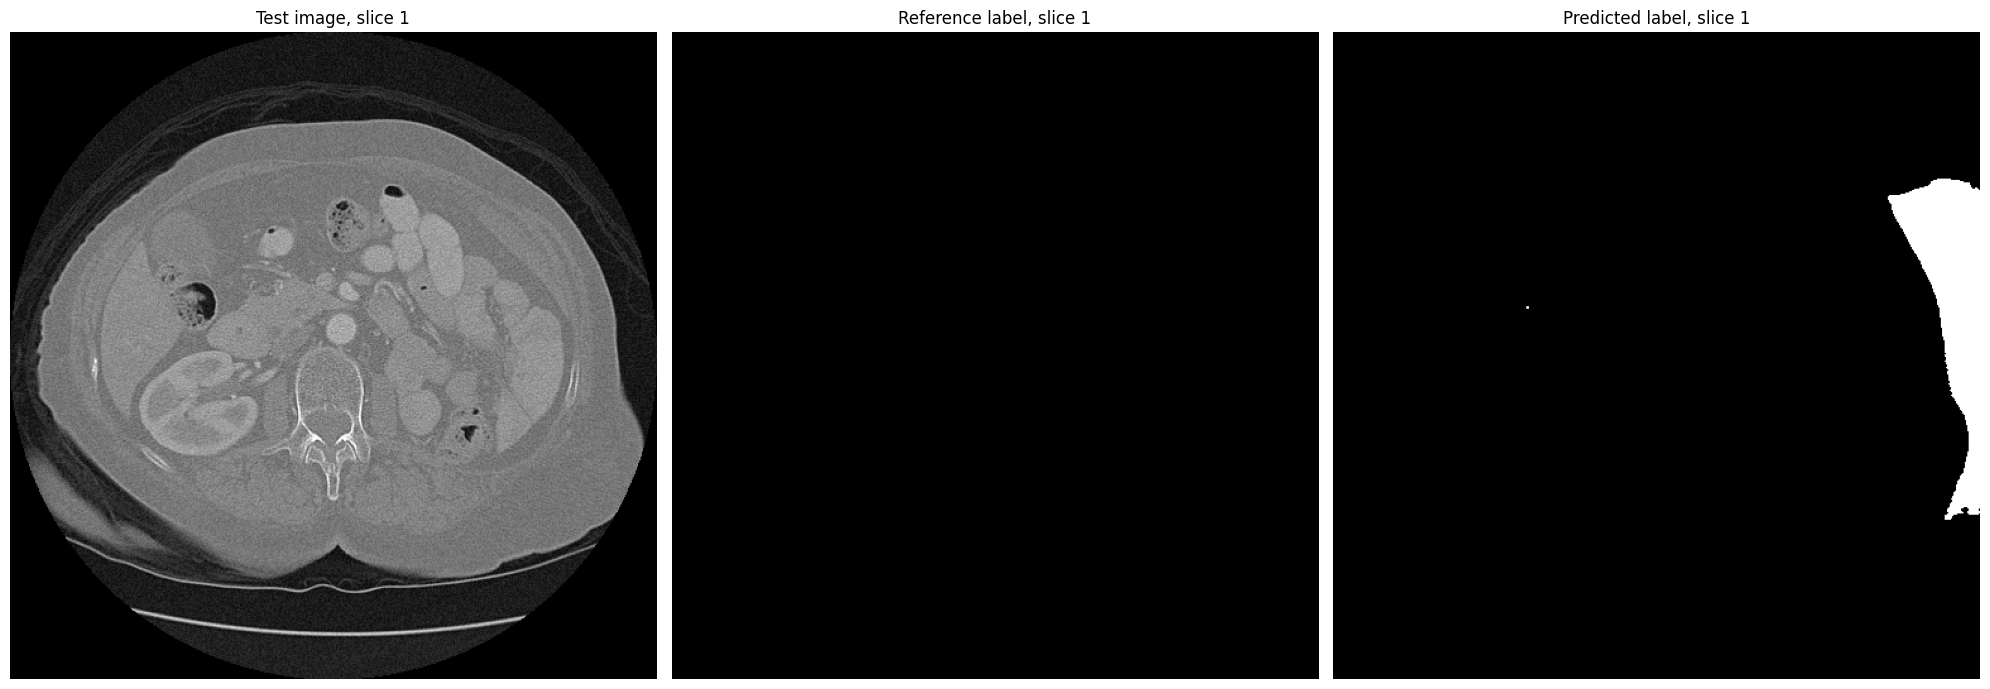

In [ ]:
import torch
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from monai.transforms import LoadImaged
from monai.inferers import sliding_window_inference
from monai.handlers.utils import from_engine
from monai.data import decollate_batch

# Charger les images avec nibabel
image_path = test_files[0]['image']
label_path = test_files[0]['label']

image_data = nib.load(image_path).get_fdata()
label_data = nib.load(label_path).get_fdata()

# Convertir en tensors PyTorch
original_image = torch.from_numpy(image_data).float()
original_label = torch.from_numpy(label_data).float()

# Vérifier la forme des images
print("Original image shape:", original_image.shape)
print("Original label shape:", original_label.shape)

# Choisir une coupe 2D
slice_idx = 1
image_slice_2d = original_image[slice_idx].detach().cpu().numpy()
label_slice_2d = original_label[slice_idx].detach().cpu().numpy()

# Charger le modèle
model.load_state_dict(torch.load("best_metric_model.pth", map_location="cpu"))
model.eval()

# Exécuter l'inférence
with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = sliding_window_inference(test_inputs, (96, 96, 96), 1, model, overlap=0.75)
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_output = from_engine(["pred"])(test_data)
        break  # Un seul batch

# Extraire la prédiction pour la classe "poumon" (index 1)
predicted_mask = torch.argmax(test_output[0], dim=0)  # Réduction sur l'axe des classes
predicted_slice = predicted_mask[slice_idx].detach().cpu().numpy()

# Afficher les résultats
plt.figure(figsize=(20, 7))

# Image originale
plt.subplot(1, 3, 1)
plt.imshow(image_slice_2d, cmap="gray", vmin=-1000, vmax=1000)
plt.title(f'Test image, slice {slice_idx}')
plt.axis('off')

# Label de référence
plt.subplot(1, 3, 2)
plt.imshow(label_slice_2d, cmap="gray")
plt.title(f'Reference label, slice {slice_idx}')
plt.axis('off')

# Prédiction
plt.subplot(1, 3, 3)
plt.imshow(predicted_slice, cmap="gray")
plt.title(f'Predicted label, slice {slice_idx}')
plt.axis('off')

plt.tight_layout()
plt.show()

Original image shape: torch.Size([117, 512, 512])
Original label shape: torch.Size([117, 512, 512])
2025-03-18 14:17:04,786 INFO image_writer.py:197 - writing: out/IMG_0078/IMG_0078_seg.nii.gz


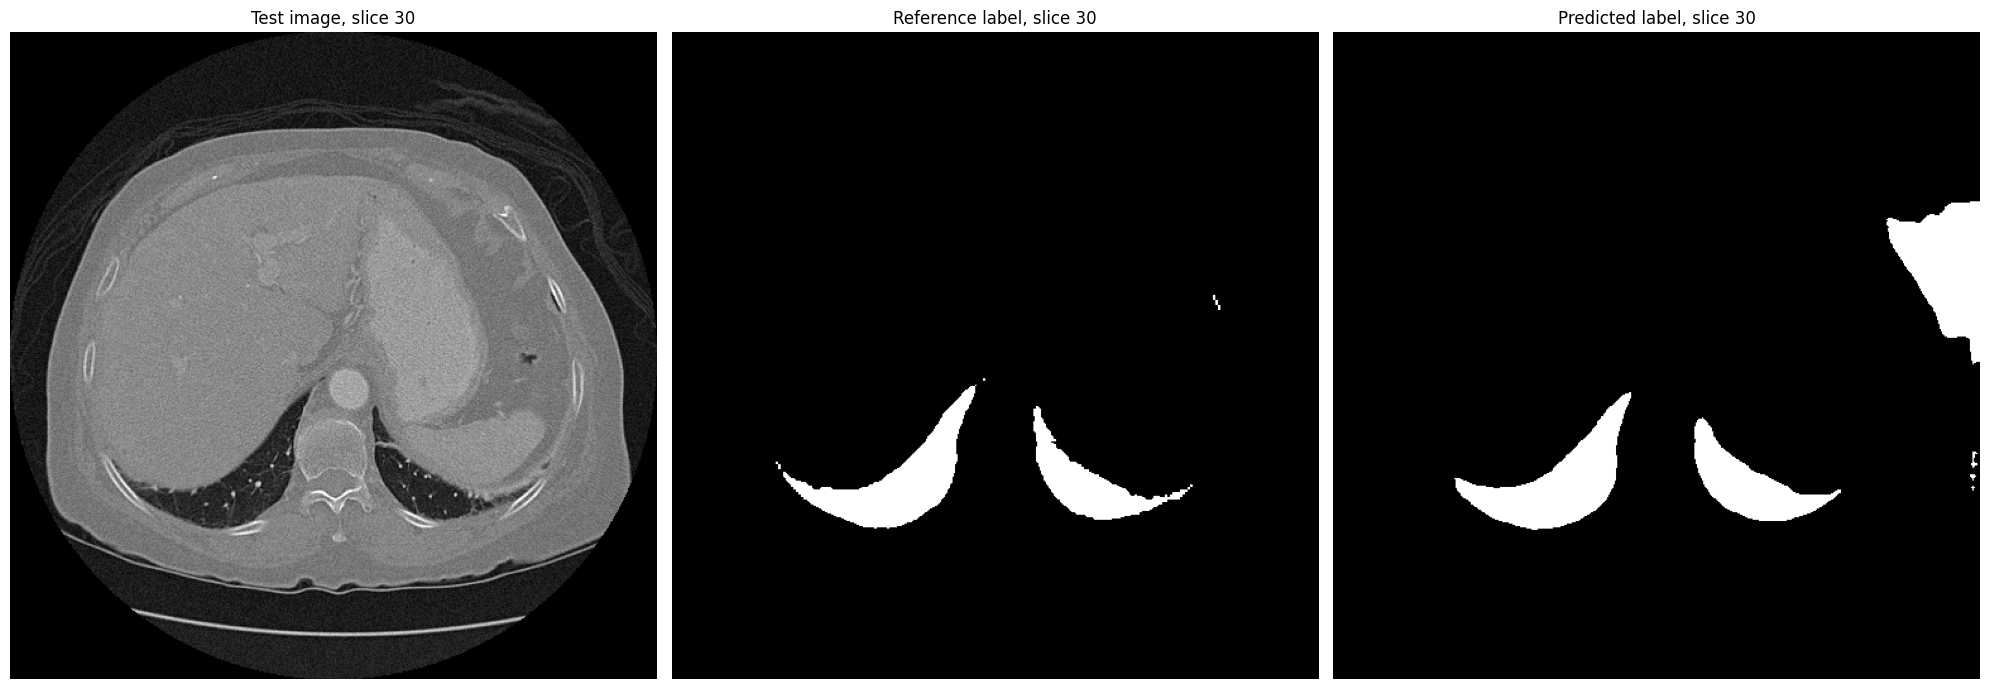

In [ ]:
import torch
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from monai.transforms import LoadImaged
from monai.inferers import sliding_window_inference
from monai.handlers.utils import from_engine
from monai.data import decollate_batch

# Charger les images avec nibabel
image_path = test_files[0]['image']
label_path = test_files[0]['label']

image_data = nib.load(image_path).get_fdata()
label_data = nib.load(label_path).get_fdata()

# Convertir en tensors PyTorch
original_image = torch.from_numpy(image_data).float()
original_label = torch.from_numpy(label_data).float()

# Vérifier la forme des images
print("Original image shape:", original_image.shape)
print("Original label shape:", original_label.shape)

# Choisir une coupe 2D
slice_idx = 30
image_slice_2d = original_image[slice_idx].detach().cpu().numpy()
label_slice_2d = original_label[slice_idx].detach().cpu().numpy()

# Charger le modèle
model.load_state_dict(torch.load("best_metric_model.pth", map_location="cpu"))
model.eval()

# Exécuter l'inférence
with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = sliding_window_inference(test_inputs, (96, 96, 96), 1, model, overlap=0.75)
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_output = from_engine(["pred"])(test_data)
        break  # Un seul batch

# Extraire la prédiction pour la classe "poumon" (index 1)
predicted_mask = torch.argmax(test_output[0], dim=0)  # Réduction sur l'axe des classes
predicted_slice = predicted_mask[slice_idx].detach().cpu().numpy()

# Afficher les résultats
plt.figure(figsize=(20, 7))

# Image originale
plt.subplot(1, 3, 1)
plt.imshow(image_slice_2d, cmap="gray", vmin=-1000, vmax=1000)
plt.title(f'Test image, slice {slice_idx}')
plt.axis('off')

# Label de référence
plt.subplot(1, 3, 2)
plt.imshow(label_slice_2d, cmap="gray")
plt.title(f'Reference label, slice {slice_idx}')
plt.axis('off')

# Prédiction
plt.subplot(1, 3, 3)
plt.imshow(predicted_slice, cmap="gray")
plt.title(f'Predicted label, slice {slice_idx}')
plt.axis('off')

plt.tight_layout()
plt.show()

Original image shape: torch.Size([117, 512, 512])
Original label shape: torch.Size([117, 512, 512])
2025-03-18 14:17:50,064 INFO image_writer.py:197 - writing: out/IMG_0078/IMG_0078_seg.nii.gz


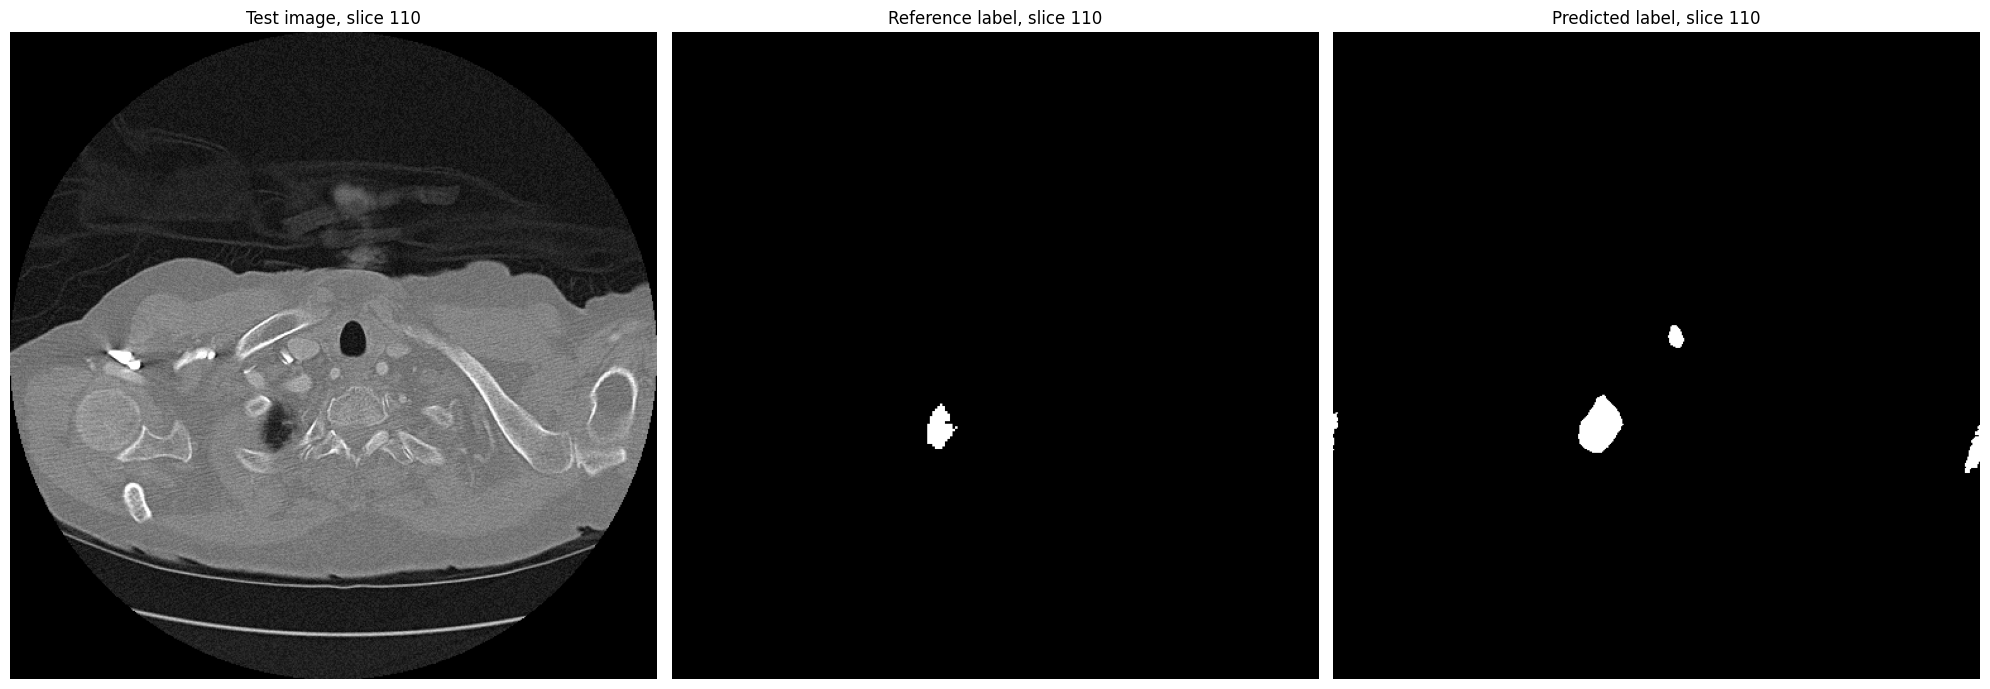

In [ ]:
import torch
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from monai.transforms import LoadImaged
from monai.inferers import sliding_window_inference
from monai.handlers.utils import from_engine
from monai.data import decollate_batch

# Charger les images avec nibabel
image_path = test_files[0]['image']
label_path = test_files[0]['label']

image_data = nib.load(image_path).get_fdata()
label_data = nib.load(label_path).get_fdata()

# Convertir en tensors PyTorch
original_image = torch.from_numpy(image_data).float()
original_label = torch.from_numpy(label_data).float()

# Vérifier la forme des images
print("Original image shape:", original_image.shape)
print("Original label shape:", original_label.shape)

# Choisir une coupe 2D
slice_idx = 110
image_slice_2d = original_image[slice_idx].detach().cpu().numpy()
label_slice_2d = original_label[slice_idx].detach().cpu().numpy()

# Charger le modèle
model.load_state_dict(torch.load("best_metric_model.pth", map_location="cpu"))
model.eval()

# Exécuter l'inférence
with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = sliding_window_inference(test_inputs, (96, 96, 96), 1, model, overlap=0.75)
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_output = from_engine(["pred"])(test_data)
        break  # Un seul batch

# Extraire la prédiction pour la classe "poumon" (index 1)
predicted_mask = torch.argmax(test_output[0], dim=0)  # Réduction sur l'axe des classes
predicted_slice = predicted_mask[slice_idx].detach().cpu().numpy()

# Afficher les résultats
plt.figure(figsize=(20, 7))

# Image originale
plt.subplot(1, 3, 1)
plt.imshow(image_slice_2d, cmap="gray", vmin=-1000, vmax=1000)
plt.title(f'Test image, slice {slice_idx}')
plt.axis('off')

# Label de référence
plt.subplot(1, 3, 2)
plt.imshow(label_slice_2d, cmap="gray")
plt.title(f'Reference label, slice {slice_idx}')
plt.axis('off')

# Prédiction
plt.subplot(1, 3, 3)
plt.imshow(predicted_slice, cmap="gray")
plt.title(f'Predicted label, slice {slice_idx}')
plt.axis('off')

plt.tight_layout()
plt.show()